# **Libraries Import**

In [18]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
from collections import Counter

# For DL Models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from PIL import Image, ImageEnhance
import os
import numpy as np
from tqdm import tqdm
import random

# Import necessary libraries
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage import feature
import cv2  # Import OpenCV for SURF feature extraction
from skimage import color
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image, ImageEnhance
import numpy as np
import torchmetrics
from sklearn.model_selection import train_test_split
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from torchvision.models import vgg16

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Miscellaneous
from tqdm import tqdm
import os
import random

# **Connecting Drive & Splitting Data**

In [2]:
train_dataset = ['G:/MISC files/Research/Brain_Tumor/classification/Training', 'G:/MISC files/Research/Brain_Tumor/mri/Training']
test_dataset = ['G:/MISC files/Research/Brain_Tumor/classification/Testing', 'G:/MISC files/Research/Brain_Tumor/mri/Testing']

# **Processing Training Data**

In [3]:
train_paths = []
train_labels = []

for train_dir in train_dataset:
    for label in os.listdir(train_dir):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(train_dir, label)):
            train_paths.append(os.path.join(train_dir, label, image))
            train_labels.append(real_label)

train_paths, train_labels = shuffle(train_paths, train_labels)

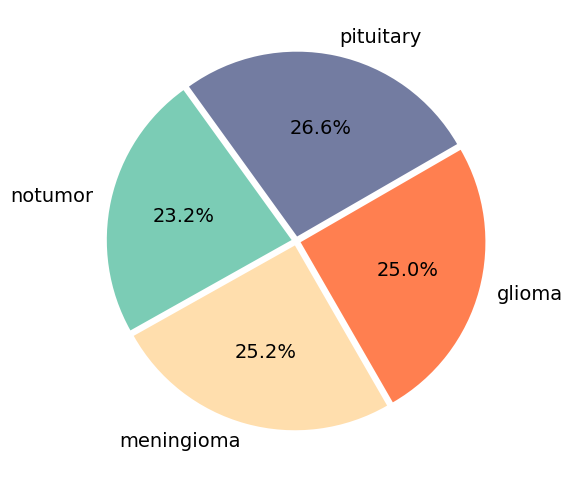

In [4]:
plt.figure(figsize=(14,6))
colors = ['#737CA1', '#7BCCB5', '#FFDEAD', '#FF7F50']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x == 'pituitary']),
         len([x for x in train_labels if x == 'notumor']),
         len([x for x in train_labels if x == 'meningioma']),
         len([x for x in train_labels if x == 'glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

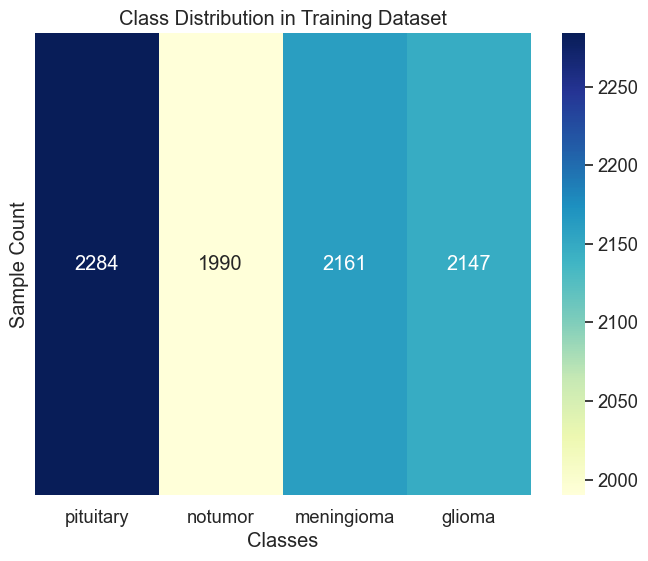

In [5]:
class_counts = dict(Counter(train_labels))

class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
class_distribution = [class_counts.get(name, 0) for name in class_names]

data_for_heatmap = [class_distribution] 

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(data_for_heatmap, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=False)
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Sample Count')
plt.show()

# **Processing Testing Data**

In [6]:
test_paths = []
test_labels = []

for test_dir in test_dataset:
    for label in os.listdir(test_dir):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(test_dir, label)):
            test_paths.append(os.path.join(test_dir, label, image))
            test_labels.append(real_label)

test_paths, test_labels = shuffle(test_paths, test_labels)

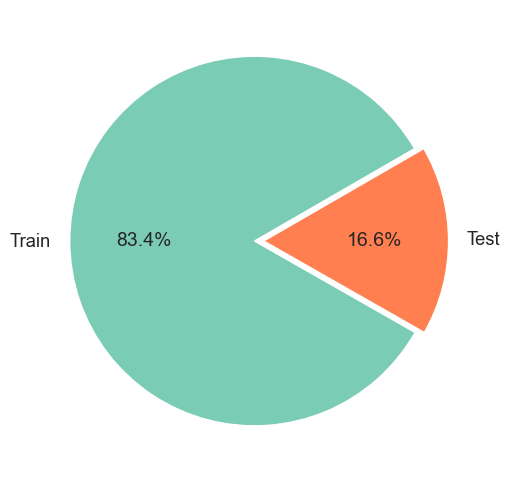

In [7]:
plt.figure(figsize=(14,6))
colors = ['#7BCCB5', '#FF7F50']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# **Image Loading, Augmentation & Visualization**

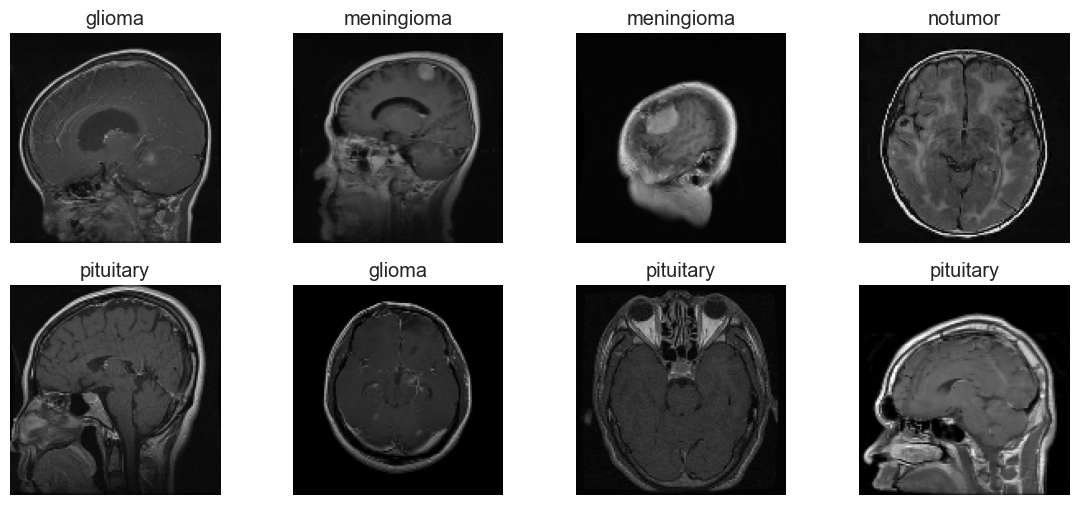

In [8]:
# IMAGE_SIZE = 128
IMAGE_SIZE = 224

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[0:9])
labels = train_labels[0:9]
fig = plt.figure(figsize=(14, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# **Encoding & Decoding The Label of Images**

In [9]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# **Building Models**

### **VGG16**

In [10]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [13]:
batch_size = 50
steps = int(len(train_paths)/batch_size)
epochs = 15
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15
171/171 [==============================] - 235s 1s/step - loss: 0.4628 - sparse_categorical_accuracy: 0.8200
Epoch 2/15
171/171 [==============================] - 246s 1s/step - loss: 0.2005 - sparse_categorical_accuracy: 0.9201
Epoch 3/15
171/171 [==============================] - 246s 1s/step - loss: 0.1194 - sparse_categorical_accuracy: 0.9546
Epoch 4/15
171/171 [==============================] - 247s 1s/step - loss: 0.0780 - sparse_categorical_accuracy: 0.9716
Epoch 5/15
171/171 [==============================] - 256s 1s/step - loss: 0.0561 - sparse_categorical_accuracy: 0.9784
Epoch 6/15
171/171 [==============================] - 249s 1s/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9869
Epoch 7/15
171/171 [==============================] - 241s 1s/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9859
Epoch 8/15
171/171 [==============================] - 251s 1s/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9856
Epoch 9/15
171/171 [====================

In [14]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/53 [00:00<?, ?it/s]

1/1 [==============================] - 1s 725ms/step


  2%|▏         | 1/53 [00:00<00:44,  1.16it/s]

1/1 [==============================] - 1s 548ms/step


  4%|▍         | 2/53 [00:01<00:37,  1.36it/s]

1/1 [==============================] - 1s 556ms/step


  6%|▌         | 3/53 [00:02<00:34,  1.44it/s]

1/1 [==============================] - 1s 553ms/step


  8%|▊         | 4/53 [00:02<00:32,  1.49it/s]

1/1 [==============================] - 1s 549ms/step


  9%|▉         | 5/53 [00:03<00:31,  1.52it/s]

1/1 [==============================] - 1s 555ms/step


 11%|█▏        | 6/53 [00:04<00:30,  1.53it/s]

1/1 [==============================] - 1s 551ms/step


 13%|█▎        | 7/53 [00:04<00:29,  1.54it/s]

1/1 [==============================] - 1s 551ms/step


 15%|█▌        | 8/53 [00:05<00:29,  1.55it/s]

1/1 [==============================] - 1s 558ms/step


 17%|█▋        | 9/53 [00:05<00:28,  1.55it/s]

1/1 [==============================] - 1s 548ms/step


 19%|█▉        | 10/53 [00:06<00:27,  1.55it/s]

1/1 [==============================] - 1s 547ms/step


 21%|██        | 11/53 [00:07<00:27,  1.55it/s]

1/1 [==============================] - 1s 554ms/step


 23%|██▎       | 12/53 [00:07<00:26,  1.53it/s]

1/1 [==============================] - 1s 549ms/step


 25%|██▍       | 13/53 [00:08<00:26,  1.53it/s]

1/1 [==============================] - 1s 552ms/step


 26%|██▋       | 14/53 [00:09<00:25,  1.55it/s]

1/1 [==============================] - 1s 558ms/step


 28%|██▊       | 15/53 [00:09<00:24,  1.55it/s]

1/1 [==============================] - 1s 538ms/step


 30%|███       | 16/53 [00:10<00:23,  1.56it/s]

1/1 [==============================] - 1s 540ms/step


 32%|███▏      | 17/53 [00:11<00:23,  1.56it/s]

1/1 [==============================] - 1s 540ms/step


 34%|███▍      | 18/53 [00:11<00:22,  1.55it/s]

1/1 [==============================] - 1s 537ms/step


 36%|███▌      | 19/53 [00:12<00:21,  1.57it/s]

1/1 [==============================] - 1s 543ms/step


 38%|███▊      | 20/53 [00:13<00:21,  1.57it/s]

1/1 [==============================] - 1s 539ms/step


 40%|███▉      | 21/53 [00:13<00:20,  1.58it/s]

1/1 [==============================] - 1s 539ms/step


 42%|████▏     | 22/53 [00:14<00:19,  1.59it/s]

1/1 [==============================] - 1s 538ms/step


 43%|████▎     | 23/53 [00:14<00:18,  1.59it/s]

1/1 [==============================] - 1s 541ms/step


 45%|████▌     | 24/53 [00:15<00:18,  1.59it/s]

1/1 [==============================] - 1s 539ms/step


 47%|████▋     | 25/53 [00:16<00:17,  1.59it/s]

1/1 [==============================] - 1s 538ms/step


 49%|████▉     | 26/53 [00:16<00:16,  1.60it/s]

1/1 [==============================] - 1s 539ms/step


 51%|█████     | 27/53 [00:17<00:16,  1.59it/s]

1/1 [==============================] - 1s 543ms/step


 53%|█████▎    | 28/53 [00:18<00:15,  1.59it/s]

1/1 [==============================] - 1s 551ms/step


 55%|█████▍    | 29/53 [00:18<00:15,  1.58it/s]

1/1 [==============================] - 1s 546ms/step


 57%|█████▋    | 30/53 [00:19<00:14,  1.58it/s]

1/1 [==============================] - 1s 540ms/step


 58%|█████▊    | 31/53 [00:19<00:13,  1.58it/s]

1/1 [==============================] - 1s 539ms/step


 60%|██████    | 32/53 [00:20<00:13,  1.58it/s]

1/1 [==============================] - 1s 540ms/step


 62%|██████▏   | 33/53 [00:21<00:12,  1.58it/s]

1/1 [==============================] - 1s 539ms/step


 64%|██████▍   | 34/53 [00:21<00:11,  1.59it/s]

1/1 [==============================] - 1s 539ms/step


 66%|██████▌   | 35/53 [00:22<00:11,  1.59it/s]

1/1 [==============================] - 1s 540ms/step


 68%|██████▊   | 36/53 [00:23<00:10,  1.59it/s]

1/1 [==============================] - 1s 541ms/step


 70%|██████▉   | 37/53 [00:23<00:10,  1.58it/s]

1/1 [==============================] - 1s 541ms/step


 72%|███████▏  | 38/53 [00:24<00:09,  1.59it/s]

1/1 [==============================] - 1s 538ms/step


 74%|███████▎  | 39/53 [00:25<00:08,  1.59it/s]

1/1 [==============================] - 1s 543ms/step


 75%|███████▌  | 40/53 [00:25<00:08,  1.58it/s]

1/1 [==============================] - 1s 541ms/step


 77%|███████▋  | 41/53 [00:26<00:07,  1.58it/s]

1/1 [==============================] - 1s 541ms/step


 79%|███████▉  | 42/53 [00:26<00:06,  1.58it/s]

1/1 [==============================] - 1s 539ms/step


 81%|████████  | 43/53 [00:27<00:06,  1.58it/s]

1/1 [==============================] - 1s 540ms/step


 83%|████████▎ | 44/53 [00:28<00:05,  1.59it/s]

1/1 [==============================] - 1s 540ms/step


 85%|████████▍ | 45/53 [00:28<00:05,  1.59it/s]

1/1 [==============================] - 1s 535ms/step


 87%|████████▋ | 46/53 [00:29<00:04,  1.60it/s]

1/1 [==============================] - 1s 538ms/step


 89%|████████▊ | 47/53 [00:30<00:03,  1.60it/s]

1/1 [==============================] - 1s 537ms/step


 91%|█████████ | 48/53 [00:30<00:03,  1.59it/s]

1/1 [==============================] - 1s 539ms/step


 92%|█████████▏| 49/53 [00:31<00:02,  1.59it/s]

1/1 [==============================] - 1s 539ms/step


 94%|█████████▍| 50/53 [00:31<00:01,  1.58it/s]

1/1 [==============================] - 1s 536ms/step


 96%|█████████▌| 51/53 [00:32<00:01,  1.60it/s]

1/1 [==============================] - 1s 540ms/step


 98%|█████████▊| 52/53 [00:33<00:00,  1.60it/s]

1/1 [==============================] - 1s 543ms/step


100%|██████████| 53/53 [00:33<00:00,  1.59it/s]

1/1 [==============================] - 0s 260ms/step


54it [00:34,  1.58it/s]                        


In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.81      0.88       400
  meningioma       0.89      0.94      0.91       421
     notumor       0.95      1.00      0.97       510
   pituitary       0.95      0.99      0.97       374

    accuracy                           0.94      1705
   macro avg       0.94      0.93      0.93      1705
weighted avg       0.94      0.94      0.93      1705



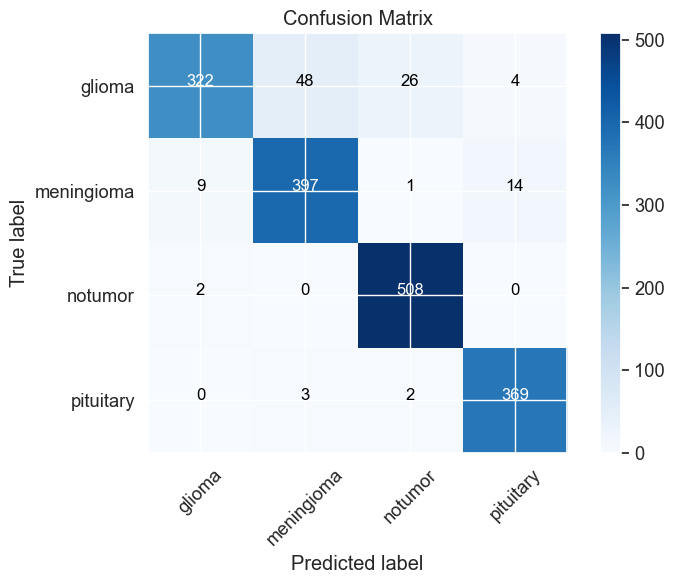

In [19]:
# Get the unique labels
classes = np.unique(y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### **Resnet50**

In [20]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block of ResNet50 to trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [21]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 27782660 (105.98 MB)
Trainable params: 5

In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [23]:
# Define batch size and number of epochs
batch_size = 50
epochs = 15
steps = int(len(train_paths) / batch_size)

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15
171/171 [==============================] - 96s 545ms/step - loss: 0.8213 - sparse_categorical_accuracy: 0.6531
Epoch 2/15
171/171 [==============================] - 111s 652ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.7473
Epoch 3/15
171/171 [==============================] - 88s 516ms/step - loss: 0.5332 - sparse_categorical_accuracy: 0.7794
Epoch 4/15
171/171 [==============================] - 87s 510ms/step - loss: 0.4826 - sparse_categorical_accuracy: 0.7998
Epoch 5/15
171/171 [==============================] - 88s 513ms/step - loss: 0.4510 - sparse_categorical_accuracy: 0.8124
Epoch 6/15
171/171 [==============================] - 89s 521ms/step - loss: 0.4163 - sparse_categorical_accuracy: 0.8288
Epoch 7/15
171/171 [==============================] - 90s 526ms/step - loss: 0.3994 - sparse_categorical_accuracy: 0.8363
Epoch 8/15
171/171 [==============================] - 87s 512ms/step - loss: 0.3798 - sparse_categorical_accuracy: 0.8446
Epoch 9/15
171/171 [===

In [24]:
# Make predictions on test data
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)


  0%|          | 0/53 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 1/53 [00:01<01:13,  1.42s/it]

1/1 [==============================] - 0s 387ms/step


  4%|▍         | 2/53 [00:01<00:44,  1.14it/s]

1/1 [==============================] - 0s 396ms/step


  6%|▌         | 3/53 [00:02<00:35,  1.40it/s]

1/1 [==============================] - 0s 410ms/step


  8%|▊         | 4/53 [00:02<00:31,  1.58it/s]

1/1 [==============================] - 0s 387ms/step


  9%|▉         | 5/53 [00:03<00:28,  1.71it/s]

1/1 [==============================] - 0s 466ms/step


 11%|█▏        | 6/53 [00:04<00:27,  1.71it/s]

1/1 [==============================] - 0s 385ms/step


 13%|█▎        | 7/53 [00:04<00:25,  1.80it/s]

1/1 [==============================] - 0s 409ms/step


 15%|█▌        | 8/53 [00:05<00:24,  1.81it/s]

1/1 [==============================] - 0s 414ms/step


 17%|█▋        | 9/53 [00:05<00:23,  1.86it/s]

1/1 [==============================] - 0s 383ms/step


 19%|█▉        | 10/53 [00:06<00:22,  1.90it/s]

1/1 [==============================] - 0s 400ms/step


 21%|██        | 11/53 [00:06<00:22,  1.87it/s]

1/1 [==============================] - 0s 413ms/step


 23%|██▎       | 12/53 [00:07<00:21,  1.88it/s]

1/1 [==============================] - 1s 503ms/step


 25%|██▍       | 13/53 [00:07<00:22,  1.77it/s]

1/1 [==============================] - 0s 423ms/step


 26%|██▋       | 14/53 [00:08<00:21,  1.79it/s]

1/1 [==============================] - 0s 399ms/step


 28%|██▊       | 15/53 [00:08<00:20,  1.82it/s]

1/1 [==============================] - 0s 432ms/step


 30%|███       | 16/53 [00:09<00:20,  1.77it/s]

1/1 [==============================] - 0s 386ms/step


 32%|███▏      | 17/53 [00:09<00:19,  1.84it/s]

1/1 [==============================] - 0s 387ms/step


 34%|███▍      | 18/53 [00:10<00:18,  1.85it/s]

1/1 [==============================] - 0s 400ms/step


 36%|███▌      | 19/53 [00:10<00:17,  1.89it/s]

1/1 [==============================] - 0s 395ms/step


 38%|███▊      | 20/53 [00:11<00:17,  1.91it/s]

1/1 [==============================] - 0s 388ms/step


 40%|███▉      | 21/53 [00:12<00:16,  1.93it/s]

1/1 [==============================] - 0s 383ms/step


 42%|████▏     | 22/53 [00:12<00:15,  1.94it/s]

1/1 [==============================] - 0s 382ms/step


 43%|████▎     | 23/53 [00:13<00:15,  1.97it/s]

1/1 [==============================] - 0s 443ms/step


 45%|████▌     | 24/53 [00:13<00:15,  1.91it/s]

1/1 [==============================] - 0s 425ms/step


 47%|████▋     | 25/53 [00:14<00:15,  1.85it/s]

1/1 [==============================] - 0s 376ms/step


 49%|████▉     | 26/53 [00:14<00:14,  1.92it/s]

1/1 [==============================] - 0s 396ms/step


 51%|█████     | 27/53 [00:15<00:13,  1.91it/s]

1/1 [==============================] - 0s 389ms/step


 53%|█████▎    | 28/53 [00:15<00:12,  1.95it/s]

1/1 [==============================] - 0s 384ms/step


 55%|█████▍    | 29/53 [00:16<00:12,  1.98it/s]

1/1 [==============================] - 0s 387ms/step


 57%|█████▋    | 30/53 [00:16<00:11,  2.00it/s]

1/1 [==============================] - 0s 443ms/step


 58%|█████▊    | 31/53 [00:17<00:11,  1.92it/s]

1/1 [==============================] - 0s 416ms/step


 60%|██████    | 32/53 [00:17<00:11,  1.90it/s]

1/1 [==============================] - 0s 433ms/step


 62%|██████▏   | 33/53 [00:18<00:10,  1.87it/s]

1/1 [==============================] - 0s 418ms/step


 64%|██████▍   | 34/53 [00:18<00:10,  1.87it/s]

1/1 [==============================] - 0s 377ms/step


 66%|██████▌   | 35/53 [00:19<00:09,  1.93it/s]

1/1 [==============================] - 0s 368ms/step


 68%|██████▊   | 36/53 [00:19<00:08,  1.99it/s]

1/1 [==============================] - 0s 368ms/step


 70%|██████▉   | 37/53 [00:20<00:07,  2.04it/s]

1/1 [==============================] - 0s 376ms/step


 72%|███████▏  | 38/53 [00:20<00:07,  2.07it/s]

1/1 [==============================] - 0s 370ms/step


 74%|███████▎  | 39/53 [00:21<00:06,  2.08it/s]

1/1 [==============================] - 0s 378ms/step


 75%|███████▌  | 40/53 [00:21<00:06,  2.06it/s]

1/1 [==============================] - 0s 372ms/step


 77%|███████▋  | 41/53 [00:22<00:05,  2.08it/s]

1/1 [==============================] - 0s 368ms/step


 79%|███████▉  | 42/53 [00:22<00:05,  2.08it/s]

1/1 [==============================] - 0s 370ms/step


 81%|████████  | 43/53 [00:23<00:04,  2.11it/s]

1/1 [==============================] - 0s 382ms/step


 83%|████████▎ | 44/53 [00:23<00:04,  2.05it/s]

1/1 [==============================] - 0s 387ms/step


 85%|████████▍ | 45/53 [00:24<00:03,  2.04it/s]

1/1 [==============================] - 0s 385ms/step


 87%|████████▋ | 46/53 [00:24<00:03,  2.06it/s]

1/1 [==============================] - 0s 366ms/step


 89%|████████▊ | 47/53 [00:25<00:02,  2.09it/s]

1/1 [==============================] - 0s 371ms/step


 91%|█████████ | 48/53 [00:25<00:02,  2.09it/s]

1/1 [==============================] - 0s 372ms/step


 92%|█████████▏| 49/53 [00:25<00:01,  2.10it/s]

1/1 [==============================] - 0s 373ms/step


 94%|█████████▍| 50/53 [00:26<00:01,  2.09it/s]

1/1 [==============================] - 0s 373ms/step


 96%|█████████▌| 51/53 [00:26<00:00,  2.10it/s]

1/1 [==============================] - 0s 380ms/step


 98%|█████████▊| 52/53 [00:27<00:00,  2.09it/s]

1/1 [==============================] - 0s 422ms/step


100%|██████████| 53/53 [00:27<00:00,  2.02it/s]

1/1 [==============================] - 1s 1s/step


54it [00:29,  1.86it/s]                        


In [25]:
# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.73      0.68      0.70       400
  meningioma       0.75      0.74      0.74       421
     notumor       0.87      0.95      0.91       510
   pituitary       0.91      0.88      0.89       374

    accuracy                           0.82      1705
   macro avg       0.81      0.81      0.81      1705
weighted avg       0.81      0.82      0.82      1705



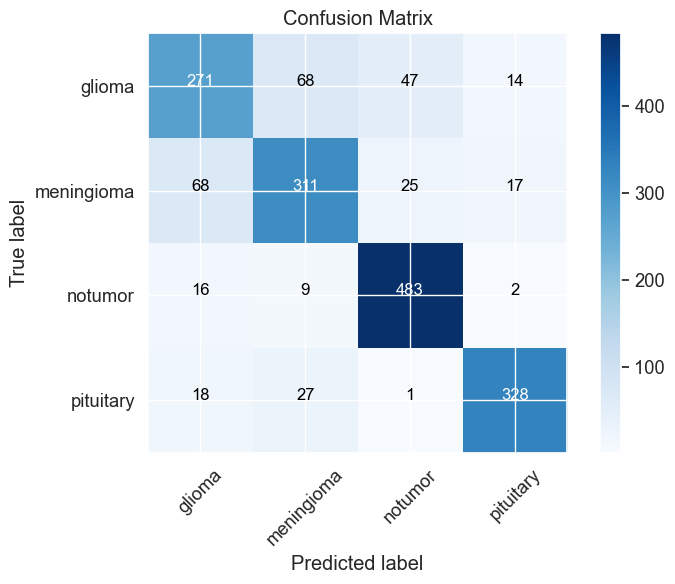

In [26]:
# Get the unique labels
classes = np.unique(y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### **InceptionV3**

In [27]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block of InceptionV3 to trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(unique_labels), activation='softmax'))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 23901220 (91.18 MB)
Trainable params: 20

In [29]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [30]:
# Define batch size and number of epochs
batch_size = 50
steps = int(len(train_paths)/batch_size)
epochs = 15
# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15
171/171 [==============================] - 61s 329ms/step - loss: 1.0823 - sparse_categorical_accuracy: 0.6510
Epoch 2/15
171/171 [==============================] - 56s 329ms/step - loss: 0.5979 - sparse_categorical_accuracy: 0.7719
Epoch 3/15
171/171 [==============================] - 56s 327ms/step - loss: 0.4793 - sparse_categorical_accuracy: 0.8149
Epoch 4/15
171/171 [==============================] - 52s 306ms/step - loss: 0.4316 - sparse_categorical_accuracy: 0.8289
Epoch 5/15
171/171 [==============================] - 61s 357ms/step - loss: 0.3742 - sparse_categorical_accuracy: 0.8548
Epoch 6/15
171/171 [==============================] - 57s 335ms/step - loss: 0.3614 - sparse_categorical_accuracy: 0.8578
Epoch 7/15
171/171 [==============================] - 51s 301ms/step - loss: 0.3140 - sparse_categorical_accuracy: 0.8763
Epoch 8/15
171/171 [==============================] - 47s 276ms/step - loss: 0.2926 - sparse_categorical_accuracy: 0.8929
Epoch 9/15
171/171 [====

In [31]:
# Make predictions on test data
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/53 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 1/53 [00:02<02:21,  2.72s/it]

1/1 [==============================] - 0s 226ms/step


  4%|▍         | 2/53 [00:03<01:11,  1.39s/it]

1/1 [==============================] - 0s 227ms/step


  6%|▌         | 3/53 [00:03<00:47,  1.05it/s]

1/1 [==============================] - 0s 228ms/step


  8%|▊         | 4/53 [00:04<00:36,  1.36it/s]

1/1 [==============================] - 0s 226ms/step


  9%|▉         | 5/53 [00:04<00:29,  1.61it/s]

1/1 [==============================] - 0s 229ms/step


 11%|█▏        | 6/53 [00:04<00:26,  1.79it/s]

1/1 [==============================] - 0s 231ms/step


 13%|█▎        | 7/53 [00:05<00:23,  1.92it/s]

1/1 [==============================] - 0s 229ms/step


 15%|█▌        | 8/53 [00:05<00:21,  2.05it/s]

1/1 [==============================] - 0s 221ms/step


 17%|█▋        | 9/53 [00:06<00:20,  2.16it/s]

1/1 [==============================] - 0s 218ms/step


 19%|█▉        | 10/53 [00:06<00:19,  2.19it/s]

1/1 [==============================] - 0s 234ms/step


 21%|██        | 11/53 [00:07<00:19,  2.18it/s]

1/1 [==============================] - 0s 222ms/step


 23%|██▎       | 12/53 [00:07<00:18,  2.22it/s]

1/1 [==============================] - 0s 212ms/step


 25%|██▍       | 13/53 [00:07<00:17,  2.26it/s]

1/1 [==============================] - 0s 222ms/step


 26%|██▋       | 14/53 [00:08<00:16,  2.30it/s]

1/1 [==============================] - 0s 216ms/step


 28%|██▊       | 15/53 [00:08<00:16,  2.34it/s]

1/1 [==============================] - 0s 220ms/step


 30%|███       | 16/53 [00:09<00:16,  2.30it/s]

1/1 [==============================] - 0s 220ms/step


 32%|███▏      | 17/53 [00:09<00:15,  2.31it/s]

1/1 [==============================] - 0s 218ms/step


 34%|███▍      | 18/53 [00:10<00:15,  2.24it/s]

1/1 [==============================] - 0s 214ms/step


 36%|███▌      | 19/53 [00:10<00:14,  2.31it/s]

1/1 [==============================] - 0s 215ms/step


 38%|███▊      | 20/53 [00:10<00:14,  2.36it/s]

1/1 [==============================] - 0s 212ms/step


 40%|███▉      | 21/53 [00:11<00:13,  2.39it/s]

1/1 [==============================] - 0s 214ms/step


 42%|████▏     | 22/53 [00:11<00:12,  2.41it/s]

1/1 [==============================] - 0s 218ms/step


 43%|████▎     | 23/53 [00:12<00:12,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


 45%|████▌     | 24/53 [00:12<00:11,  2.46it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████▋     | 25/53 [00:12<00:11,  2.45it/s]

1/1 [==============================] - 0s 215ms/step


 49%|████▉     | 26/53 [00:13<00:10,  2.47it/s]

1/1 [==============================] - 0s 213ms/step


 51%|█████     | 27/53 [00:13<00:10,  2.46it/s]

1/1 [==============================] - 0s 208ms/step


 53%|█████▎    | 28/53 [00:14<00:10,  2.49it/s]

1/1 [==============================] - 0s 215ms/step


 55%|█████▍    | 29/53 [00:14<00:09,  2.48it/s]

1/1 [==============================] - 0s 205ms/step


 57%|█████▋    | 30/53 [00:14<00:09,  2.49it/s]

1/1 [==============================] - 0s 210ms/step


 58%|█████▊    | 31/53 [00:15<00:08,  2.46it/s]

1/1 [==============================] - 0s 209ms/step


 60%|██████    | 32/53 [00:15<00:08,  2.45it/s]

1/1 [==============================] - 0s 213ms/step


 62%|██████▏   | 33/53 [00:16<00:08,  2.49it/s]

1/1 [==============================] - 0s 209ms/step


 64%|██████▍   | 34/53 [00:16<00:07,  2.52it/s]

1/1 [==============================] - 0s 208ms/step


 66%|██████▌   | 35/53 [00:16<00:07,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 68%|██████▊   | 36/53 [00:17<00:06,  2.50it/s]

1/1 [==============================] - 0s 214ms/step


 70%|██████▉   | 37/53 [00:17<00:06,  2.52it/s]

1/1 [==============================] - 0s 209ms/step


 72%|███████▏  | 38/53 [00:18<00:05,  2.55it/s]

1/1 [==============================] - 0s 210ms/step


 74%|███████▎  | 39/53 [00:18<00:05,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


 75%|███████▌  | 40/53 [00:18<00:05,  2.46it/s]

1/1 [==============================] - 0s 210ms/step


 77%|███████▋  | 41/53 [00:19<00:04,  2.40it/s]

1/1 [==============================] - 0s 207ms/step


 79%|███████▉  | 42/53 [00:19<00:04,  2.44it/s]

1/1 [==============================] - 0s 209ms/step


 81%|████████  | 43/53 [00:20<00:03,  2.51it/s]

1/1 [==============================] - 0s 209ms/step


 83%|████████▎ | 44/53 [00:20<00:03,  2.52it/s]

1/1 [==============================] - 0s 206ms/step


 85%|████████▍ | 45/53 [00:20<00:03,  2.53it/s]

1/1 [==============================] - 0s 208ms/step


 87%|████████▋ | 46/53 [00:21<00:02,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 89%|████████▊ | 47/53 [00:21<00:02,  2.55it/s]

1/1 [==============================] - 0s 209ms/step


 91%|█████████ | 48/53 [00:22<00:02,  2.49it/s]

1/1 [==============================] - 0s 211ms/step


 92%|█████████▏| 49/53 [00:22<00:01,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


 94%|█████████▍| 50/53 [00:22<00:01,  2.45it/s]

1/1 [==============================] - 0s 214ms/step


 96%|█████████▌| 51/53 [00:23<00:00,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 98%|█████████▊| 52/53 [00:23<00:00,  2.48it/s]

1/1 [==============================] - 0s 212ms/step


100%|██████████| 53/53 [00:24<00:00,  2.49it/s]

1/1 [==============================] - 2s 2s/step


54it [00:26,  2.05it/s]                        


In [32]:
# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.71      0.82       400
  meningioma       0.82      0.90      0.86       421
     notumor       0.92      1.00      0.96       510
   pituitary       0.88      0.92      0.90       374

    accuracy                           0.89      1705
   macro avg       0.90      0.88      0.88      1705
weighted avg       0.90      0.89      0.89      1705



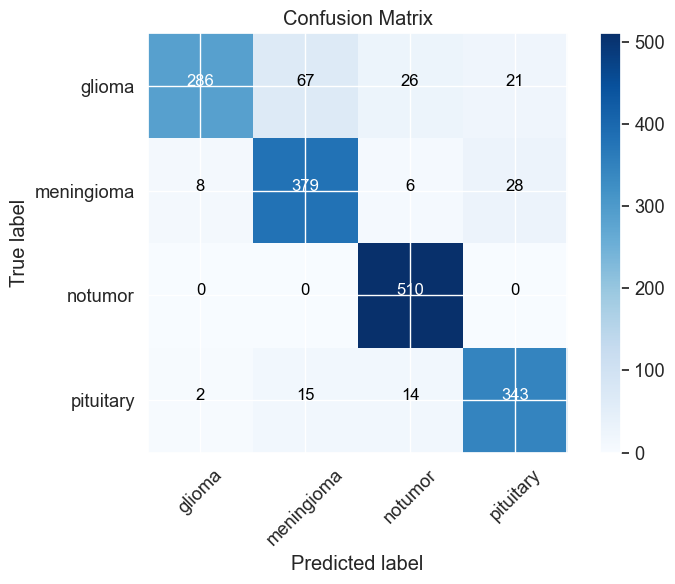

In [33]:
# Get the unique labels
classes = np.unique(y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### **MobileNetV3**

In [34]:
from keras.applications import MobileNetV3Small
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Load pre-trained MobileNetV3 model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block of MobileNetV3 to trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))  # Change dropout rate
model.add(Dense(256, activation='relu'))  # Change number of neurons
model.add(Dropout(0.3))  # Change dropout rate
model.add(Dense(len(unique_labels), activation='softmax'))

4334752/4334752 [==============================] - 4s 1us/step


In [35]:
# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 4, 4, 576)         939120    
 al)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_6 (Dropout)         (None, 9216)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2359552   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                      

In [38]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [39]:
# Define batch size and number of epochs
batch_size = 50
steps = int(len(train_paths)/batch_size)
epochs = 15

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


Epoch 1/15
171/171 [==============================] - 34s 179ms/step - loss: 1.1586 - sparse_categorical_accuracy: 0.4926
Epoch 2/15
171/171 [==============================] - 30s 178ms/step - loss: 1.0186 - sparse_categorical_accuracy: 0.5529
Epoch 3/15
171/171 [==============================] - 30s 177ms/step - loss: 0.9724 - sparse_categorical_accuracy: 0.5656
Epoch 4/15
171/171 [==============================] - 30s 177ms/step - loss: 0.9435 - sparse_categorical_accuracy: 0.5808
Epoch 5/15
171/171 [==============================] - 30s 176ms/step - loss: 0.9268 - sparse_categorical_accuracy: 0.5829
Epoch 6/15
171/171 [==============================] - 31s 183ms/step - loss: 0.8961 - sparse_categorical_accuracy: 0.6056
Epoch 7/15
171/171 [==============================] - 31s 180ms/step - loss: 0.8920 - sparse_categorical_accuracy: 0.6015
Epoch 8/15
171/171 [==============================] - 30s 178ms/step - loss: 0.8702 - sparse_categorical_accuracy: 0.6105
Epoch 9/15
171/171 [====

In [40]:
# Make predictions on test data
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/53 [00:00<?, ?it/s]

1/1 [==============================] - 1s 831ms/step


  2%|▏         | 1/53 [00:00<00:48,  1.06it/s]

1/1 [==============================] - 0s 80ms/step


  4%|▍         | 2/53 [00:01<00:26,  1.94it/s]

1/1 [==============================] - 0s 84ms/step


  6%|▌         | 3/53 [00:01<00:19,  2.59it/s]

1/1 [==============================] - 0s 81ms/step


  8%|▊         | 4/53 [00:01<00:15,  3.21it/s]

1/1 [==============================] - 0s 81ms/step


  9%|▉         | 5/53 [00:01<00:13,  3.67it/s]

1/1 [==============================] - 0s 86ms/step


 11%|█▏        | 6/53 [00:02<00:11,  3.97it/s]

1/1 [==============================] - 0s 76ms/step


 13%|█▎        | 7/53 [00:02<00:10,  4.28it/s]

1/1 [==============================] - 0s 80ms/step


 15%|█▌        | 8/53 [00:02<00:09,  4.56it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█▋        | 9/53 [00:02<00:09,  4.73it/s]

1/1 [==============================] - 0s 75ms/step


 19%|█▉        | 10/53 [00:02<00:08,  4.84it/s]

1/1 [==============================] - 0s 76ms/step


 21%|██        | 11/53 [00:02<00:08,  4.83it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 12/53 [00:03<00:08,  4.79it/s]

1/1 [==============================] - 0s 70ms/step


 25%|██▍       | 13/53 [00:03<00:07,  5.01it/s]

1/1 [==============================] - 0s 71ms/step


 26%|██▋       | 14/53 [00:03<00:07,  5.21it/s]

1/1 [==============================] - 0s 68ms/step


 28%|██▊       | 15/53 [00:03<00:07,  5.15it/s]

1/1 [==============================] - 0s 74ms/step


 30%|███       | 16/53 [00:03<00:07,  5.23it/s]

1/1 [==============================] - 0s 73ms/step


 32%|███▏      | 17/53 [00:04<00:06,  5.31it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 18/53 [00:04<00:06,  5.26it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 19/53 [00:04<00:06,  5.48it/s]

1/1 [==============================] - 0s 76ms/step


 38%|███▊      | 20/53 [00:04<00:06,  5.48it/s]

1/1 [==============================] - 0s 75ms/step


 40%|███▉      | 21/53 [00:04<00:05,  5.51it/s]

1/1 [==============================] - 0s 73ms/step


 42%|████▏     | 22/53 [00:05<00:05,  5.51it/s]

1/1 [==============================] - 0s 74ms/step


 43%|████▎     | 23/53 [00:05<00:05,  5.53it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▌     | 24/53 [00:05<00:05,  5.53it/s]

1/1 [==============================] - 0s 78ms/step


 47%|████▋     | 25/53 [00:05<00:05,  5.53it/s]

1/1 [==============================] - 0s 74ms/step


 49%|████▉     | 26/53 [00:05<00:04,  5.56it/s]

1/1 [==============================] - 0s 76ms/step


 51%|█████     | 27/53 [00:05<00:04,  5.57it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 28/53 [00:06<00:04,  5.46it/s]

1/1 [==============================] - 0s 77ms/step


 55%|█████▍    | 29/53 [00:06<00:04,  5.42it/s]

1/1 [==============================] - 0s 77ms/step


 57%|█████▋    | 30/53 [00:06<00:04,  5.39it/s]

1/1 [==============================] - 0s 74ms/step


 58%|█████▊    | 31/53 [00:06<00:04,  5.44it/s]

1/1 [==============================] - 0s 74ms/step


 60%|██████    | 32/53 [00:06<00:03,  5.40it/s]

1/1 [==============================] - 0s 71ms/step


 62%|██████▏   | 33/53 [00:07<00:03,  5.58it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████▍   | 34/53 [00:07<00:03,  5.66it/s]

1/1 [==============================] - 0s 70ms/step


 66%|██████▌   | 35/53 [00:07<00:03,  5.65it/s]

1/1 [==============================] - 0s 68ms/step


 68%|██████▊   | 36/53 [00:07<00:02,  5.78it/s]

1/1 [==============================] - 0s 72ms/step


 70%|██████▉   | 37/53 [00:07<00:02,  5.84it/s]

1/1 [==============================] - 0s 92ms/step


 72%|███████▏  | 38/53 [00:07<00:02,  5.65it/s]

1/1 [==============================] - 0s 72ms/step


 74%|███████▎  | 39/53 [00:08<00:02,  5.40it/s]

1/1 [==============================] - 0s 71ms/step


 75%|███████▌  | 40/53 [00:08<00:02,  5.37it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 41/53 [00:08<00:02,  5.53it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▉  | 42/53 [00:08<00:01,  5.52it/s]

1/1 [==============================] - 0s 72ms/step


 81%|████████  | 43/53 [00:08<00:01,  5.65it/s]

1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 44/53 [00:08<00:01,  5.67it/s]

1/1 [==============================] - 0s 72ms/step


 85%|████████▍ | 45/53 [00:09<00:01,  5.72it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 46/53 [00:09<00:01,  5.77it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▊ | 47/53 [00:09<00:01,  5.84it/s]

1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 48/53 [00:09<00:00,  5.71it/s]

1/1 [==============================] - 0s 72ms/step


 92%|█████████▏| 49/53 [00:09<00:00,  5.71it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 50/53 [00:10<00:00,  5.66it/s]

1/1 [==============================] - 0s 76ms/step


 96%|█████████▌| 51/53 [00:10<00:00,  5.61it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 52/53 [00:10<00:00,  5.71it/s]

1/1 [==============================] - 0s 70ms/step


100%|██████████| 53/53 [00:10<00:00,  5.81it/s]

1/1 [==============================] - 1s 727ms/step


54it [00:11,  4.77it/s]                        


In [41]:
# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.54      0.64      0.58       400
  meningioma       0.56      0.15      0.24       421
     notumor       0.69      0.59      0.64       510
   pituitary       0.50      0.90      0.64       374

    accuracy                           0.56      1705
   macro avg       0.57      0.57      0.52      1705
weighted avg       0.58      0.56      0.53      1705



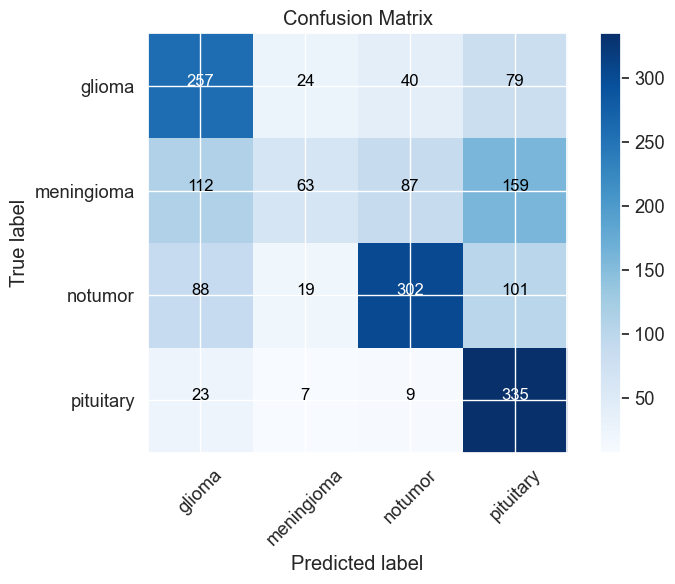

In [43]:
# Get the unique labels
classes = np.unique(y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### **EfficientNet**

In [47]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block of EfficientNetB0 to trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))  # Adjust dropout rate if needed
model.add(Dense(256, activation='relu'))  # Adjust number of neurons if needed
model.add(Dropout(0.3))  # Adjust dropout rate if needed
model.add(Dense(len(unique_labels), activation='softmax'))


16705208/16705208 [==============================] - 9s 1us/step


In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_8 (Dropout)         (None, 20480)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               5243136   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                      

In [49]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [50]:
# Define batch size and number of epochs
batch_size = 50
steps = int(len(train_paths)/batch_size)
epochs = 15

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


Epoch 1/15
171/171 [==============================] - 81s 430ms/step - loss: 1.5535 - sparse_categorical_accuracy: 0.2481
Epoch 2/15
171/171 [==============================] - 72s 424ms/step - loss: 1.3884 - sparse_categorical_accuracy: 0.2609
Epoch 3/15
171/171 [==============================] - 71s 417ms/step - loss: 1.3868 - sparse_categorical_accuracy: 0.2620
Epoch 4/15
171/171 [==============================] - 71s 417ms/step - loss: 1.3852 - sparse_categorical_accuracy: 0.2691
Epoch 5/15
171/171 [==============================] - 73s 425ms/step - loss: 1.3830 - sparse_categorical_accuracy: 0.2632
Epoch 6/15
171/171 [==============================] - 83s 488ms/step - loss: 1.3795 - sparse_categorical_accuracy: 0.2756
Epoch 7/15
171/171 [==============================] - 84s 490ms/step - loss: 1.3730 - sparse_categorical_accuracy: 0.2947
Epoch 8/15
171/171 [==============================] - 84s 490ms/step - loss: 1.3719 - sparse_categorical_accuracy: 0.3005
Epoch 9/15
171/171 [====

In [51]:
# Make predictions on test data
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/53 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 1/53 [00:01<01:42,  1.97s/it]

1/1 [==============================] - 0s 227ms/step


  4%|▍         | 2/53 [00:02<00:51,  1.01s/it]

1/1 [==============================] - 0s 213ms/step


  6%|▌         | 3/53 [00:02<00:34,  1.44it/s]

1/1 [==============================] - 0s 206ms/step


  8%|▊         | 4/53 [00:02<00:26,  1.85it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 5/53 [00:03<00:21,  2.23it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█▏        | 6/53 [00:03<00:18,  2.51it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 7/53 [00:03<00:16,  2.78it/s]

1/1 [==============================] - 0s 187ms/step


 15%|█▌        | 8/53 [00:04<00:15,  2.99it/s]

1/1 [==============================] - 0s 247ms/step


 17%|█▋        | 9/53 [00:04<00:14,  2.99it/s]

1/1 [==============================] - 0s 218ms/step


 19%|█▉        | 10/53 [00:04<00:14,  2.98it/s]

1/1 [==============================] - 0s 210ms/step


 21%|██        | 11/53 [00:05<00:13,  3.01it/s]

1/1 [==============================] - 0s 190ms/step


 23%|██▎       | 12/53 [00:05<00:13,  3.11it/s]

1/1 [==============================] - 0s 182ms/step


 25%|██▍       | 13/53 [00:05<00:12,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 26%|██▋       | 14/53 [00:05<00:11,  3.30it/s]

1/1 [==============================] - 0s 185ms/step


 28%|██▊       | 15/53 [00:06<00:11,  3.39it/s]

1/1 [==============================] - 0s 198ms/step


 30%|███       | 16/53 [00:06<00:11,  3.19it/s]

1/1 [==============================] - 0s 192ms/step


 32%|███▏      | 17/53 [00:06<00:11,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 34%|███▍      | 18/53 [00:07<00:10,  3.26it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▌      | 19/53 [00:07<00:11,  2.99it/s]

1/1 [==============================] - 0s 262ms/step


 38%|███▊      | 20/53 [00:08<00:12,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


 40%|███▉      | 21/53 [00:08<00:12,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 42%|████▏     | 22/53 [00:08<00:12,  2.44it/s]

1/1 [==============================] - 0s 273ms/step


 43%|████▎     | 23/53 [00:09<00:12,  2.36it/s]

1/1 [==============================] - 0s 260ms/step


 45%|████▌     | 24/53 [00:09<00:12,  2.33it/s]

1/1 [==============================] - 0s 266ms/step


 47%|████▋     | 25/53 [00:10<00:12,  2.30it/s]

1/1 [==============================] - 0s 262ms/step


 49%|████▉     | 26/53 [00:10<00:11,  2.27it/s]

1/1 [==============================] - 0s 263ms/step


 51%|█████     | 27/53 [00:11<00:11,  2.24it/s]

1/1 [==============================] - 0s 264ms/step


 53%|█████▎    | 28/53 [00:11<00:11,  2.26it/s]

1/1 [==============================] - 0s 264ms/step


 55%|█████▍    | 29/53 [00:12<00:10,  2.25it/s]

1/1 [==============================] - 0s 259ms/step


 57%|█████▋    | 30/53 [00:12<00:10,  2.23it/s]

1/1 [==============================] - 0s 304ms/step


 58%|█████▊    | 31/53 [00:13<00:10,  2.13it/s]

1/1 [==============================] - 0s 286ms/step


 60%|██████    | 32/53 [00:13<00:10,  2.09it/s]

1/1 [==============================] - 0s 293ms/step


 62%|██████▏   | 33/53 [00:14<00:09,  2.09it/s]

1/1 [==============================] - 0s 259ms/step


 64%|██████▍   | 34/53 [00:14<00:08,  2.15it/s]

1/1 [==============================] - 0s 280ms/step


 66%|██████▌   | 35/53 [00:14<00:08,  2.11it/s]

1/1 [==============================] - 0s 263ms/step


 68%|██████▊   | 36/53 [00:15<00:07,  2.15it/s]

1/1 [==============================] - 0s 272ms/step


 70%|██████▉   | 37/53 [00:15<00:07,  2.18it/s]

1/1 [==============================] - 0s 272ms/step


 72%|███████▏  | 38/53 [00:16<00:06,  2.18it/s]

1/1 [==============================] - 0s 256ms/step


 74%|███████▎  | 39/53 [00:16<00:06,  2.18it/s]

1/1 [==============================] - 0s 264ms/step


 75%|███████▌  | 40/53 [00:17<00:06,  2.15it/s]

1/1 [==============================] - 0s 257ms/step


 77%|███████▋  | 41/53 [00:17<00:05,  2.20it/s]

1/1 [==============================] - 0s 273ms/step


 79%|███████▉  | 42/53 [00:18<00:05,  2.16it/s]

1/1 [==============================] - 0s 269ms/step


 81%|████████  | 43/53 [00:18<00:04,  2.18it/s]

1/1 [==============================] - 0s 264ms/step


 83%|████████▎ | 44/53 [00:19<00:04,  2.19it/s]

1/1 [==============================] - 0s 264ms/step


 85%|████████▍ | 45/53 [00:19<00:03,  2.22it/s]

1/1 [==============================] - 0s 273ms/step


 87%|████████▋ | 46/53 [00:19<00:03,  2.21it/s]

1/1 [==============================] - 0s 273ms/step


 89%|████████▊ | 47/53 [00:20<00:02,  2.27it/s]

1/1 [==============================] - 0s 321ms/step


 91%|█████████ | 48/53 [00:20<00:02,  2.16it/s]

1/1 [==============================] - 0s 298ms/step


 92%|█████████▏| 49/53 [00:21<00:01,  2.12it/s]

1/1 [==============================] - 0s 282ms/step


 94%|█████████▍| 50/53 [00:21<00:01,  2.03it/s]

1/1 [==============================] - 0s 344ms/step


 96%|█████████▌| 51/53 [00:22<00:00,  2.00it/s]

1/1 [==============================] - 0s 341ms/step


 98%|█████████▊| 52/53 [00:22<00:00,  1.93it/s]

1/1 [==============================] - 0s 342ms/step


100%|██████████| 53/53 [00:23<00:00,  1.87it/s]

1/1 [==============================] - 2s 2s/step


54it [00:26,  2.07it/s]                        


In [53]:
# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.30      0.87      0.44       400
  meningioma       0.29      0.05      0.09       421
     notumor       0.56      0.36      0.44       510
   pituitary       0.26      0.09      0.13       374

    accuracy                           0.34      1705
   macro avg       0.35      0.34      0.28      1705
weighted avg       0.37      0.34      0.29      1705



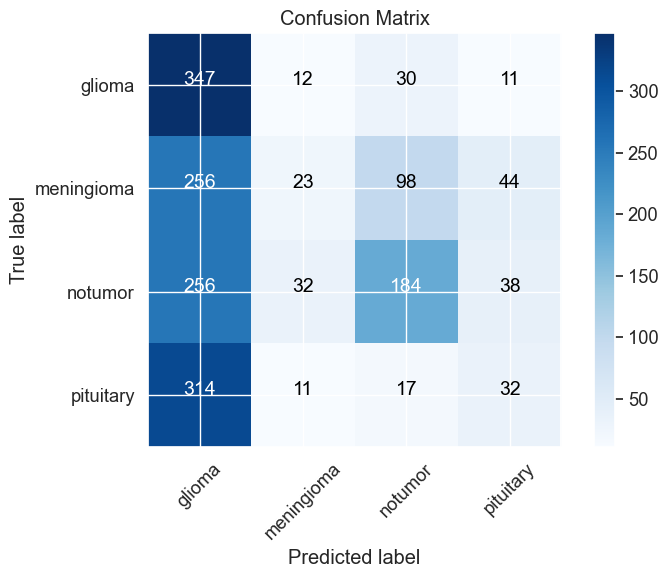

In [52]:
# Get the unique labels
classes = np.unique(y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()